In [ ]:
from Bio import SeqIO
import os

os.environ["WORKING_DIR"] = "/rds/general/user/prelucio/projects/tmstorage/live/openspliceAI/openspliceai"
os.environ["MODEL_DIR"] = "/home/prelucio/Pablo/openspliceAI/model_best.pt"

os.environ["INPUT_FILE"] = "/home/prelucio/Pablo/openspliceAI/QFS4_FWD/QFS4_FWD.gbk"
os.environ["OUTPUT_DIR"] = "/home/prelucio/Pablo/openspliceAI"

In [9]:
# Input/Output from environment
gbk_file = os.environ["INPUT_FILE"]      # Full path to GenBank file
output_dir = os.environ["OUTPUT_DIR"]    # Directory for results

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Derive FASTA filename from GBK filename
base_name = os.path.splitext(os.path.basename(gbk_file))[0].replace(" ", "_")  # e.g. "AGG2073_dsx_with_reporter"
fasta_file = os.path.join(output_dir, f"{base_name}.fasta")

# Convert GenBank → FASTA
count = SeqIO.convert(gbk_file, "genbank", fasta_file, "fasta")
print(f"Converted {count} records from {gbk_file} to FASTA")

#Export fasta file to environment
os.environ["FASTA_FILE"] = fasta_file

print("FASTA file written to:", fasta_file)

Converted 1 records from /home/prelucio/Pablo/openspliceAI/QFS4_FWD/QFS4_FWD.gbk to FASTA
FASTA file written to: /home/prelucio/Pablo/openspliceAI/QFS4_FWD.fasta


In [10]:
# Generate acceptor and donor sites prediction bed files
pred_output = f'{os.environ["OUTPUT_DIR"]}/predictions'

!mkdir -p "{pred_output}"  # make sure the directory exists

!openspliceai predict \
    --model "{os.environ['MODEL_DIR']}" \
    --input-sequence "{os.environ['FASTA_FILE']}" \
    --flanking-size 10000 \
    --threshold 0.0001 \
    --predict-all \
    --output-dir "{pred_output}"


Deep learning framework that decodes splicing across species


 ██████╗ ██████╗ ███████╗███╗   ██╗███████╗██████╗ ██╗     ██╗ ██████╗███████╗ █████╗ ██╗
██╔═══██╗██╔══██╗██╔════╝████╗  ██║██╔════╝██╔══██╗██║     ██║██╔════╝██╔════╝██╔══██╗██║
██║   ██║██████╔╝█████╗  ██╔██╗ ██║███████╗██████╔╝██║     ██║██║     █████╗  ███████║██║
██║   ██║██╔═══╝ ██╔══╝  ██║╚██╗██║╚════██║██╔═══╝ ██║     ██║██║     ██╔══╝  ██╔══██║██║
╚██████╔╝██║     ███████╗██║ ╚████║███████║██║     ███████╗██║╚██████╗███████╗██║  ██║██║
 ╚═════╝ ╚═╝     ╚══════╝╚═╝  ╚═══╝╚══════╝╚═╝     ╚══════╝╚═╝ ╚═════╝╚══════╝╚═╝  ╚═╝╚═╝
    
0.0.4

Running SpliceAI-toolkit with 'predict' mode
Running predict with SL: 5000, flanking_size: 10000, threshold: 9.999999747378752e-05, in all mode.
          model: /home/prelucio/Pablo/openspliceAI/model_best.pt, 
          input_sequence: /home/prelucio/Pablo/openspliceAI/QFS4_FWD.fasta, 
          gff_file: None,
          output_dir: /home/prelucio/Pablo/openspliceAI/predictions,


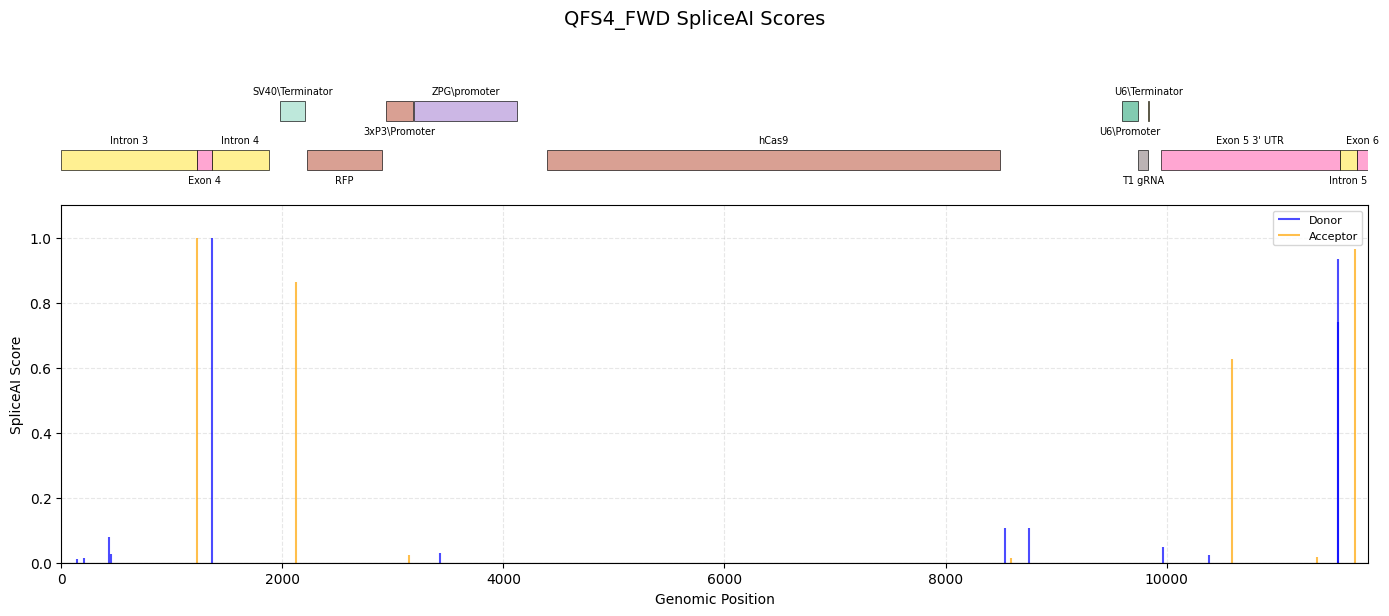

In [ ]:
from Bio import SeqIO
import matplotlib.pyplot as plt
import pandas as pd
import os
from matplotlib.patches import Rectangle

# --- Settings ---
gbk_file = os.environ["INPUT_FILE"]
pred_output = f'{os.environ["OUTPUT_DIR"]}/predictions'
base_name = os.path.splitext(os.path.basename(gbk_file))[0].replace(" ", "_")
show_misc_features = False
rect_height = 0.2
track_spacing = 0.5

# --- Paths ---
donors = f"{pred_output}/SpliceAI_5000_10000/donor_predictions.bed"
acceptors = f"{pred_output}/SpliceAI_5000_10000/acceptor_predictions.bed"

# --- Read donor/acceptor files ---
columns = ['chrom', 'start', 'end', 'name', 'value', 'strand', 'coord_type']
df1 = pd.read_csv(donors, sep='\t', names=columns, header=None)
df2 = pd.read_csv(acceptors, sep='\t', names=columns, header=None)

for df in [df1, df2]:
    df["start"] = pd.to_numeric(df["start"], errors="coerce")
    df["value"] = pd.to_numeric(df["value"], errors="coerce")
    df.dropna(subset=["start", "value"], inplace=True)

# Filter by score
df1_filtered = df1[df1["value"] > 0.01]
df2_filtered = df2[df2["value"] > 0.01]

# --- Parse GenBank features ---
features = []
sequence_length = 0
for record in SeqIO.parse(gbk_file, "genbank"):
    sequence_length = len(record.seq)
    for feature in record.features:
        if feature.type in ["primer_bind", "source"]:
            continue
        if "translation" in feature.qualifiers:
            continue

        start = int(feature.location.start)
        end = int(feature.location.end)

        label = feature.qualifiers.get("gene",
                 feature.qualifiers.get("label",
                 [feature.type]))[0]

        color = feature.qualifiers.get("ApEinfo_revcolor",
                feature.qualifiers.get("ApEinfo_fwdcolor",
                ["#808080"]))[0]

        # Assign group
        if feature.type in ["exon", "intron", "gene", 'UTR']:
            group = "gene_structure"
        elif feature.type in ["promoter", "terminator"]:
            group = "regulatory"
        else:
            group = "misc"

        features.append((start, end, label, color, group))

# --- Determine feature groups to plot ---
all_groups = ["gene_structure", "regulatory", "misc"]
GROUP_ORDER = [g for g in all_groups if g != "misc" or show_misc_features]
GROUP_Y = {group: i for i, group in enumerate(GROUP_ORDER)}
label_offsets = {group: 0 for group in GROUP_ORDER}

# --- Plot ---
fig, (ax2, ax) = plt.subplots(2, 1, figsize=(14, 6), sharex=True,
                              gridspec_kw={'height_ratios': [1, 3]})

# --- Top panel: Feature tracks (ax2) ---
for start, end, label, color, group in features:
    if group == "misc" and not show_misc_features:
        continue
    ypos = GROUP_Y[group] * track_spacing
    rect = Rectangle((start, ypos), end - start, rect_height,
                     facecolor=color, edgecolor="black", linewidth=0.5, alpha=0.9)
    ax2.add_patch(rect)

    # Stagger labels
    if label_offsets[group] % 2 == 0:
        label_y = ypos + rect_height + 0.05
        va = "bottom"
    else:
        label_y = ypos - 0.05
        va = "top"
    ax2.text((start + end)/2, label_y, label, ha="center", va=va, fontsize=7)
    label_offsets[group] += 1

# Axes formatting for feature tracks
ax2.set_ylim(-0.2, len(GROUP_ORDER)*track_spacing)
ax2.set_yticks([])
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

# Remove x-axis ticks and labels for top plot
ax2.tick_params(axis='x', bottom=False, labelbottom=False)

# --- Bottom panel: SpliceAI predictions (ax) ---
ax.vlines(df1_filtered["start"], ymin=0, ymax=df1_filtered["value"],
          color="blue", alpha=0.7, label="Donor")
ax.vlines(df2_filtered["start"], ymin=0, ymax=df2_filtered["value"],
          color="orange", alpha=0.7, label="Acceptor")
ax.axhline(0, color="black", linewidth=0.8)
ax.set_ylabel("SpliceAI Score")
ax.set_ylim(0, max(df1_filtered["value"].max(), df2_filtered["value"].max()) * 1.1)
ax.legend(loc="upper right", fontsize=8)
ax.grid(True, linestyle="--", alpha=0.3)

# Add genomic position axis at the bottom
ax.set_xlim(0, sequence_length)
ax.set_xlabel("Genomic Position")
ax.tick_params(axis='x', bottom=True, labelbottom=True)

# Set figure title at the top
fig.suptitle(f"{base_name} SpliceAI Scores", fontsize=14, y=1.02)

plt.tight_layout()
plt.show()
